In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import sys
#sys.path.append("C:/GitHub\robust_federated_learning")
import random
import os
#os.chdir('../nfs/Shared/robust_federated_learning/')
import gc
import cv2
import tensorflow.keras as keras
import util.experiment_runner as experiment_runner
#import imgaug as aug
import numpy as np
import tensorflow as tf
import pandas as pd
#import imgaug as aug
#import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import resnet50
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Get the path to the normal and pneumonia sub-directories
from pathlib import Path
from util.model import mlp_model_factory, cnn_model_factory, res_model, CNN_model_xray, CNN_model_xray_initialize
from prepare_data.pneumonia import load_data, load_img

#res_model_factory = res_model(pooling = None)
res_model_factory = res_model(pooling = 'avg')

plt.rc('font', size=24)           # controls default text sizes
plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=24)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)      # fontsize of the tick labels
plt.rc('ytick', labelsize=24)     # fontsize of the tick labels
plt.rc('legend', fontsize=24)     # legend fontsize
plt.rc('figure', titlesize=24)    # fontsize of the figure title

root_path = Path('./prepare_data/CellData/chest_xray')
train_dir = root_path / 'train'
val_dir = root_path / 'val'
test_dir = root_path / 'test'

# Augmentation sequence 
#seq = iaa.OneOf([
#    iaa.Fliplr(), # horizontal flips
#    iaa.Affine(rotate=20), # roatation
#    iaa.Multiply((1.2, 1.5))]) #random brightness
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

seed=111
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#aug.seed(seed)

In [2]:
train_data = load_data(train_dir)
train_data.head()

,image,label
0,prepare_data\CellData\chest_xray\train\NORMAL\...,0
1,prepare_data\CellData\chest_xray\train\NORMAL\...,0
2,prepare_data\CellData\chest_xray\train\PNEUMON...,1
3,prepare_data\CellData\chest_xray\train\PNEUMON...,1
4,prepare_data\CellData\chest_xray\train\PNEUMON...,1


In [3]:
model = res_model_factory()
input_shape = (150,150)
#input_shape = (224,224)
initial_lr = 1e-4
epochs = 1000
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(initial_lr, decay = 1e-5)
model.compile(
      optimizer = optimizer,
      loss = loss_fn,
      metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
      ],
    )

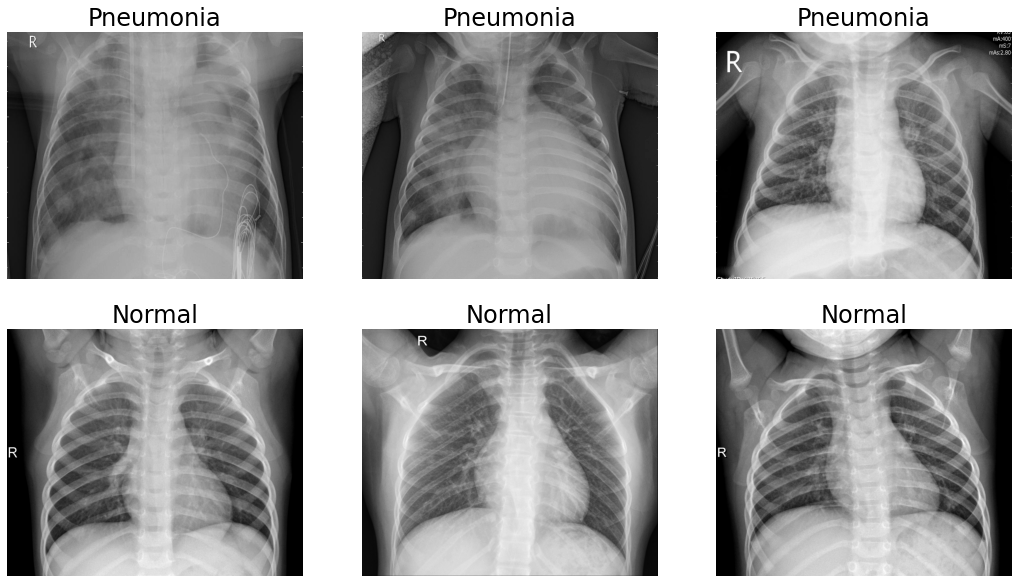

14782

In [4]:
plot_numbers = 3
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:plot_numbers]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:plot_numbers]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
from skimage.io import imread
f, ax = plt.subplots(2,plot_numbers, figsize=(6*plot_numbers,10))
for i in range(2*plot_numbers):
    img = imread(samples[i])
    ax[i//plot_numbers, i%plot_numbers].imshow(img, cmap='gray')
    if i<plot_numbers:
        ax[i//plot_numbers, i%plot_numbers].set_title("Pneumonia")
    else:
        ax[i//plot_numbers, i%plot_numbers].set_title("Normal")
    ax[i//plot_numbers, i%plot_numbers].axis('off')
    ax[i//plot_numbers, i%plot_numbers].set_aspect('auto')
plt.show()
f.savefig('plot/pneumonia_images.png', format='png', bbox_inches='tight')
del f, ax, img, samples
gc.collect()

In [5]:
batch_size = 16
nb_train_steps = train_data.shape[0]//batch_size
es = EarlyStopping(patience = 10)
chkpt_path = Path('experiments/test_pneumonia/best_model')
chkpt_path.mkdir(parents=True, exist_ok=True)
chkpt = ModelCheckpoint(filepath=chkpt_path/'model', save_best_only=True, save_weights_only=True)

"""
def data_gen(data, batch_size):
    import imgaug.augmenters as iaa
    gen = iaa.OneOf([
        iaa.Fliplr(), # horizontal flips
        iaa.Affine(rotate=20), # roatation
        iaa.Multiply((1.2, 1.5))]) #random brightness
    
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = gen.augment_image(img)
                aug_img2 = gen.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

generator = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=0.2,
        brightness_range=(1.2,1.5),
        )

train_generator = generator.flow_from_directory(
        train_dir,
        target_size=input_shape,
        batch_size=batch_size,
        class_mode='binary')

#train_generator = data_gen(data=train_data, batch_size=batch_size)
"""
train_x, train_y = load_img(train_dir, input_shape = input_shape)
print("Total number of validation examples: ", train_x.shape)
print("Total number of labels:", train_y.shape)

Total number of validation examples:  (5216, 150, 150, 3)
Total number of labels: (5216,)


In [6]:
val_x, val_y = load_img(val_dir, input_shape = input_shape)
print("Total number of validation examples: ", val_x.shape)
print("Total number of labels:", val_y.shape)
test_x, test_y = load_img(test_dir, input_shape = input_shape)
print("Total number of validation examples: ", test_x.shape)
print("Total number of labels:", test_y.shape)

Total number of validation examples:  (16, 150, 150, 3)
Total number of labels: (16,)
Total number of validation examples:  (624, 150, 150, 3)
Total number of labels: (624,)


In [7]:
self_split_val = True
if self_split_val:
    train_x = np.concatenate((train_x, val_x), axis = 0)
    train_y = np.concatenate((train_y, val_y), axis = 0)
    shuffled = np.random.permutation(5232)
    val_x = train_x[shuffled,...][:int(5232*0.1):,...]
    val_y = train_y[shuffled,...][:int(5232*0.1):,...]
    x_train = train_x[shuffled,...][int(5232*0.1):,...]
    y_train = train_y[shuffled,...][int(5232*0.1):,...]
    del shuffled
    gc.collect()
    print("Total number of validation examples: ", train_x.shape)
    print("Total number of labels:", train_y.shape)
    print("Total number of validation examples: ", val_x.shape)
    print("Total number of labels:", val_y.shape)

Total number of validation examples:  (5232, 150, 150, 3)
Total number of labels: (5232,)
Total number of validation examples:  (523, 150, 150, 3)
Total number of labels: (523,)


In [8]:
train_model = False

if train_model:
    #model.fit(train_generator, 
    model.fit(train_x, train_y, 
              epochs=epochs, steps_per_epoch=nb_train_steps,
              #validation_data=(val_x, val_y[:,1].reshape(-1,1)),
              validation_data=(val_x, val_y),
              callbacks=[es, chkpt],
              class_weight={0:1.0, 1:0.35})
    model.save_weights(chkpt_path/'model')
else:
    model.load_weights(chkpt_path/'model')
    print("load model from {}".format(chkpt_path/'model'))

load model from experiments\test_pneumonia\best_model\model


loss = 0.5527585744857788, accuracy = 0.8413461446762085, precision = 0.8284424543380737, recall = 0.9410256147384644  


<Figure size 432x288 with 0 Axes>

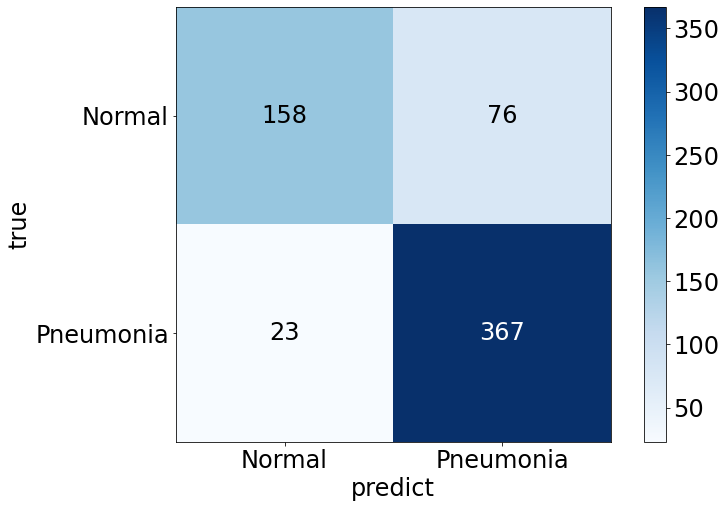

In [9]:
model.compile(
      optimizer = optimizer,
      loss = loss_fn,
      metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
      ],
    )
loss, acc, precision, recall = model.evaluate(test_x, test_y, verbose=0, batch_size=16)
#Great recall, low false negative (type-2 error)
print("loss = {}, accuracy = {}, precision = {}, recall = {}  ".format(loss,acc, precision, recall))

# Get the confusion matrix
# Get predictions
preds = model.predict(test_x, batch_size=16)
preds = np.around(preds).astype(int)
# Original labels = test_y
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(test_y, preds)
plt.figure()
fig, ax = plot_confusion_matrix(cm, figsize = (12,8), hide_ticks=True,cmap=plt.cm.Blues, colorbar = True)
ax.set_ylabel('true', fontsize = 24)
ax.set_xlabel('predict', fontsize = 24)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 24)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 24)
plt.show()
fig.savefig('plot/exp_test_pneumonia_resnet_confusion_matrix.png', format='png', bbox_inches='tight')